### Anomaly Detection

In [62]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [63]:
%watermark -a 'Durga' -v -d -p numpy,pandas,matplotlib,sklearn,pyculiarity,seaborn

Durga 2016-12-31 

CPython 2.7.12
IPython 5.1.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.3
sklearn 0.18.1
pyculiarity 0.0.2
seaborn 0.7.1


In [64]:
%matplotlib inline

# general libs
import sys
import numpy as np
import pandas as pd
import sklearn

#plotting libs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, AutoDateLocator, DateFormatter

# date time libs
import datetime as dt
from datetime import timedelta
import statsmodels.api as sm 

# ml libs
from pyculiarity import detect_ts
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# CSS Fileb
from IPython.core.display import HTML
from IPython.display import Image

# Style Setting
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

In [65]:
# Notebook Style Setting
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css));

#### APIs...

In [66]:
##### DATA API ###########

def read_metric_data(csv_name):
    '''
        Read data from a given csv file.
        CSV format: [server_name, timestamp, value]
        Timestamp format: YYYY-MM-DD HH:mm:SS
        Lines begining with # are ignored as comments.
    '''
    # Read from csv file.
    df = pd.read_csv(csv_name, index_col=1, parse_dates=True, names=[ 'server', 'value'], comment='#', quotechar="'", sep=",")
    if(df.isnull().value.any()): 
        #print ("{0} - missing data row count#: {1}".format(csv_name, np.count_nonzero(df1.isnull().values)))
        df = df.fillna(method='ffill', limit=2) # Fill last value upto two consequtive slots
    print("{0} --- #(rows:columns): {1}".format(csv_name, df.shape))
    return df

def rename_series(series, prefix='v'):
    s = series.unique()
    newS = pd.Series(np.arange(len(s), dtype=np.int))
    newS = newS.apply(lambda x:  prefix + str(x))
    d = dict(zip(s, newS))
    newSeries =series.map(d)
    return newSeries

def expand_df(df, ef=2, freq='D'):
    d = df.copy()
    d1 = pd.concat([df]*ef, ignore_index=True)
    d1.index = pd.date_range(df.index[0], periods=len(d1), freq=freq)
    return d1

In [67]:
##### Anomaly API ###########

def detect_anomalies(df, inject_anomalies=False, title='Title'):
    data = df.copy()
    dataset = pd.DataFrame(data.value, columns=['value'])
    dataset.index = data.index
    dataset['timestamp'] = data.index
    dataset = dataset[['timestamp', 'value']]

    if(inject_anomalies==True):
        # Inject anomalies
        sample = dataset.sample(n=5, replace=True)
        #sample = dataset.sample(frac=0.05)
        dataset['value'] = dataset['value'].add(sample.value, fill_value=0)

    # Detect anomalies
    results = detect_ts(dataset, max_anoms=0.05, alpha=0.001, direction='both', threshold='p99', only_last=None)
    
    # make a nice plot
    create_anomaly_plot(dataset, results, title)
    
    # return
    return results

def create_anomaly_plot(dataset, results, title='Title'):
    f, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
    ax[0].plot(dataset['timestamp'], dataset['value'], 'b')
    ax[0].plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
    ax[0].set_title(title + ": " + 'Detected Anomalies')
    ax[1].set_xlabel('Time Stamp')
    ax[0].set_ylabel('Capacity (GB)')
    ax[1].plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
    ax[1].set_ylabel('Anomaly Magnitude (GB)')
    plt.legend(loc='best')
    plt.show()

def create_shape_plots(xlabel, ylabel, title, df):
    #Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    
    # Box-Whiskers Plot
    x = df.pivot(columns='week_days', values='diff')
    x = x.rename(columns={0: 'Mon', 1: 'Tue', 2:'Wed', 3:'Thur', 4:'Fri', 5:'Sat', 6:'Sun'})
    g1 = sns.violinplot(data=x, palette=sns.color_palette(), split=True, ax=axes[0])
    g1.set_xlabel(xlabel, fontweight='bold', fontsize=12)
    g1.set_ylabel(ylabel, fontweight='bold', fontsize=12)
    g1.set_title(title)

    # Swarm Plot
    g2 = sns.stripplot(data=df['diff'], jitter=True, size=4, color=".1", linewidth=0, ax=axes[1])
    g3 = sns.violinplot(data=df['diff'], palette=sns.color_palette(), split=True, ax=axes[1])
    g3.set_xlabel('')
    g3.set_ylabel(ylabel, fontweight='bold', fontsize=12)
    g3.set_title(title)
    return

In [68]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

#### Reading & Processing Data...

In [69]:
# Read capacity used metric
df_used1 = read_metric_data("data/capacity/kelsey-capused-d.txt")
df_used2 = read_metric_data("data\capacity\dogfood-v1-capused-d.txt")
df_total = read_metric_data("data\capacity\dogfood-v1-captotal-d.txt")

# revise server values
df_used1.server = rename_series(df_used1.server, prefix="v")
df_used2.server = rename_series(df_used2.server, prefix="v")
df_total.server = rename_series(df_total.server, prefix="v")

# Preprocess Data
df_used1.loc[:,('value')] = (df_used1.value/(1024*1024*1024)).round(2)
df_used2.loc[:,('value')] = (df_used2.value/(1024*1024*1024)).round(2)
df_total.loc[:,('value')] = (df_total.value/(1024*1024*1024)).round(2)

# group data by server
g1 = df_used1.groupby('server')
g2 = df_used2.groupby('server')

#df.loc[:,'diff'] = df.value.diff()

data/capacity/kelsey-capused-d.txt --- #(rows:columns): (4156, 2)
data\capacity\dogfood-v1-capused-d.txt --- #(rows:columns): (92, 2)
data\capacity\dogfood-v1-captotal-d.txt --- #(rows:columns): (92, 2)


#### Summarize data....

In [70]:
# expand data
vdf0 = expand_df(g1.get_group("v0"), ef=10, freq='D')
vdf2 = expand_df(g2.get_group("v0"), ef=10, freq='D')
vdf40 = expand_df(g1.get_group("v40"), ef=10, freq='D')

summary = pd.DataFrame()
summary['v0'] = vdf0.describe().value
summary['v2'] = vdf2.describe().value
summary['v40'] = vdf40.describe().value
summary = summary.drop("count", axis=0)
summary = summary.round(2)

note: Also look for dark colors in each colums


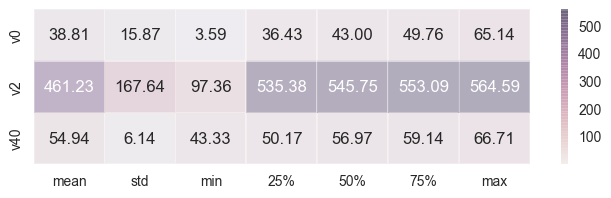

In [71]:
f, ax = plt.subplots(figsize=(8, 2))
sns.heatmap(summary.T, linewidths=.5, alpha=0.3, annot=True, fmt=".2f")
print("note: Also look for dark colors in each colums")

#### Anomaly Detection...

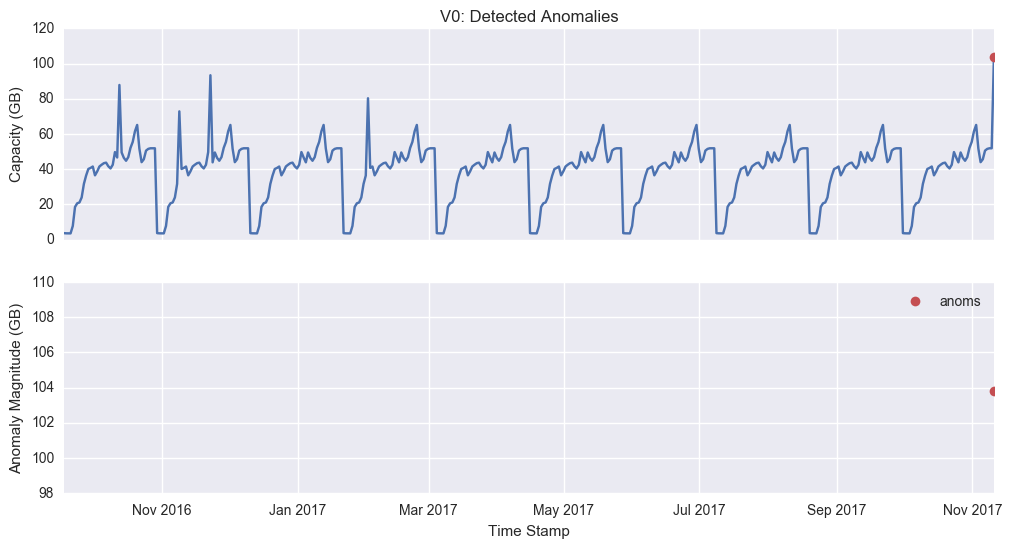

V0-Anomalies: 
 timestamp
2017-11-10 17:00:00    103.8
Name: anoms, dtype: float64


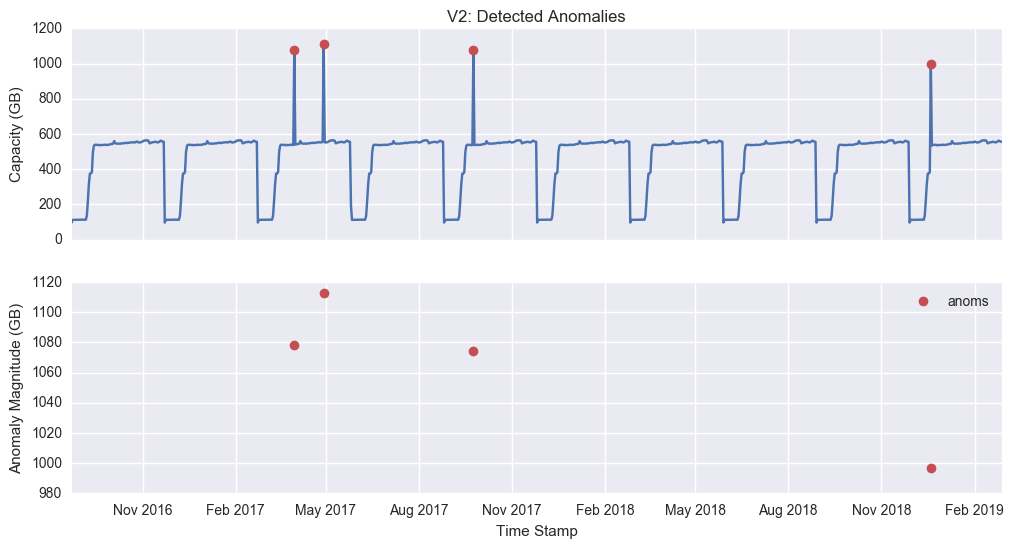

V2-Anomalies: 
 timestamp
2017-03-30 20:00:00    1078.50
2017-04-28 20:00:00    1112.68
2017-09-23 20:00:00    1074.54
2018-12-19 20:00:00     996.62
Name: anoms, dtype: float64


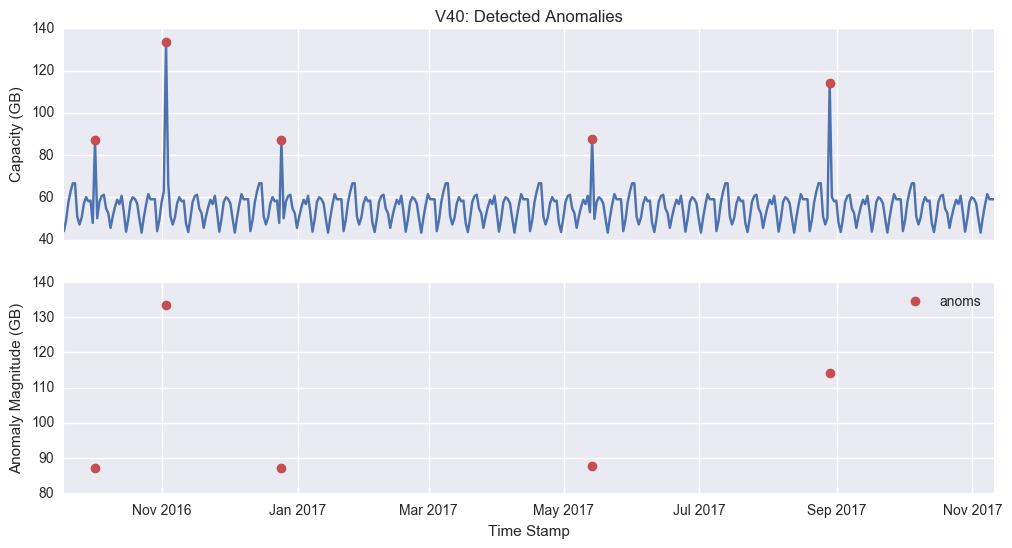

V40-Anomalies: 
 timestamp
2016-10-01 17:00:00     87.28
2016-11-02 17:00:00    133.38
2016-12-24 17:00:00     87.28
2017-05-13 17:00:00     87.64
2017-08-28 17:00:00    114.26
Name: anoms, dtype: float64


In [72]:
anomalies = detect_anomalies(vdf0, inject_anomalies=True, title='V0')
print("V0-Anomalies: \n %s"%(anomalies['anoms'].anoms))

anomalies = detect_anomalies(vdf2, inject_anomalies=True, title='V2')
print("V2-Anomalies: \n %s"%(anomalies['anoms'].anoms))

anomalies = detect_anomalies(vdf40, inject_anomalies=True, title='V40')
print("V40-Anomalies: \n %s"%(anomalies['anoms'].anoms))